# Iris dataset - Regressão Logística - 3 classes

## Objetivos

Este notebook ilustra o problema de classificação.

O objetivo é classificar as amostras da Íris em 3 classes.
- o alvo é o índice da classe: 0, 1 ou 2
- função de perda é Entropia Cruzada
- rede é uma camada densa linear com duas entradas e três saídas (n. de classes)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmax_CrossEntropy_Otimizacao.png)

## Importação das bibliotecas

In [ ]:
%matplotlib inline
import os
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from IPython import display

## Dataset: Leitura, normalização e visualização dos dados

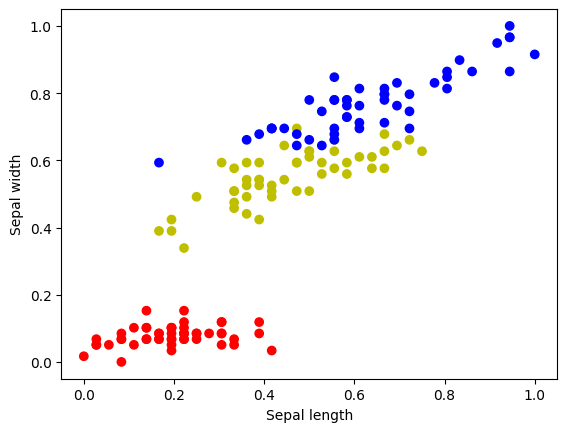

In [ ]:
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
# normalização
Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc/Xs

Y = iris.target
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [ ]:
X_tensor = torch.FloatTensor(Xc)  # Entrada é FloatTensor
Y_tensor = torch.LongTensor(Y)    # Classe é LongTensor

In [ ]:
Y_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

## Construindo o modelo da rede

A saída da rede é composta por um neurônio para cada classe. A saída é denominada *scores* ou logitos:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLogisticaRede_2_3.png)

In [ ]:
model = nn.Linear(2,3)  # 2 entradas e 3 saídas

In [ ]:
model.state_dict()

OrderedDict([('weight',
              tensor([[ 0.6802,  0.4842],
                      [ 0.6468, -0.6774],
                      [-0.1091,  0.1318]])),
             ('bias', tensor([-0.1411, -0.1420,  0.4151]))])

### Fazendo um predict

In [ ]:
out = model(Variable(X_tensor[:4,:])) # 4 amostras
out

tensor([[ 0.0428, -0.0442,  0.3998],
        [ 0.0051, -0.0801,  0.4059],
        [-0.0409, -0.1046,  0.4097],
        [-0.0434, -0.1455,  0.4172]], grad_fn=<AddmmBackward0>)

In [ ]:
oo = F.softmax(out,dim=1)
oo

tensor([[0.2989, 0.2740, 0.4271],
        [0.2931, 0.2692, 0.4377],
        [0.2851, 0.2675, 0.4474],
        [0.2867, 0.2589, 0.4544]], grad_fn=<SoftmaxBackward0>)

### Calculando as probabilidades com Softmax

- [Wikipedia:Softmax_function](https://en.wikipedia.org/wiki/Softmax_function)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/softmax.png)

In [ ]:
F.softmax(out,dim=1)*100

tensor([[29.8899, 27.3986, 42.7115],
        [29.3138, 26.9203, 43.7659],
        [28.5092, 26.7516, 44.7392],
        [28.6698, 25.8876, 45.4425]], grad_fn=<MulBackward0>)

### Predição da classe

In [ ]:
prob,y_pred = torch.max(F.softmax(out,dim=1),dim=1)
print(y_pred)
print(prob)

tensor([2, 2, 2, 2])
tensor([0.4271, 0.4377, 0.4474, 0.4544], grad_fn=<MaxBackward0>)


## Treinamento

### Classe para visualização dinâmica

In [ ]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

def predict_prob(model, inputs):
    outputs = model(Variable(inputs))
    outputs = F.softmax(outputs,dim=1)
    predicts, _ = torch.max(outputs, 1)

    return predicts.data.numpy()

class MyPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(12, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 3, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.set_title('Perda x Época')
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 3, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax2.set_title('Fronteiras de decisão')

        self.ax3 = self.fig.add_subplot(1, 3, 3)
        self.ax3.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax3.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax3.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax3.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax3.set_title('Máxima probabilidade')

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                #Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
                Zc = predict(self.model,torch.FloatTensor(self.X_grid))
                Zc = Zc.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Zc, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                Zp = predict_prob(self.model,torch.FloatTensor(self.X_grid))
                Zp = Zp.reshape(self.xx.shape)

                self.ax3.pcolormesh(self.xx, self.yy, Zp, cmap=plt.cm.magma)
                colors = np.array(['r','y','b'])
                self.ax3.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

### Laço principal de treinamento da Regressão Logística por Softmax

In [ ]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Final loss: 0.2060505747795105


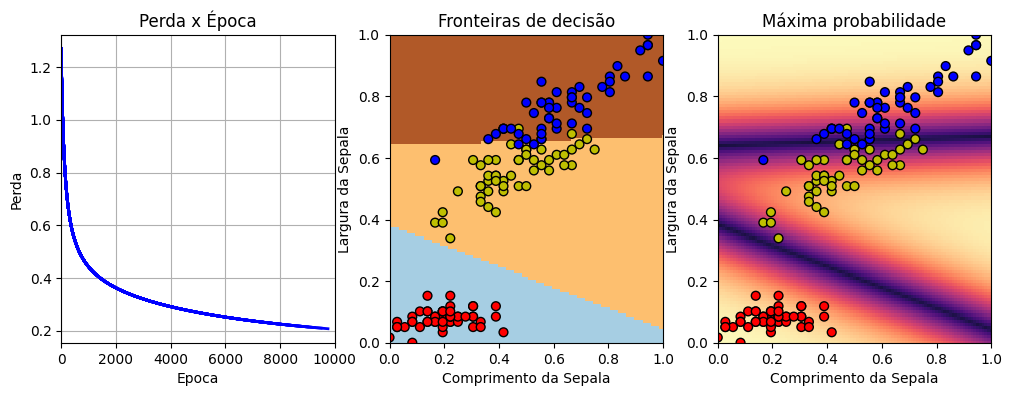

In [ ]:
nb_epoch = 10000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    # calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())

    my_plot.on_epoch_end(i, {'loss': loss.data.item()});
    final_loss = loss.data.item()

print('Final loss:', final_loss)

## Avaliação

### Parâmetros após treinamento

In [ ]:
model.state_dict()

OrderedDict([('weight',
              tensor([[ -2.5892, -14.7817],
                      [  2.1863,  -0.7304],
                      [  1.6207,  15.4506]])),
             ('bias', tensor([ 7.0691,  1.6889, -8.6260]))])

### Salvando os parâmetros treinados

In [ ]:
os.makedirs('../models',exist_ok=True)
torch.save(model.state_dict(),'../models/RegrLog_Iris.pt')

In [ ]:
! ls ../models/

RegrLog_Iris.pt


In [ ]:
nn.init.constant(model.weight,0)
model.state_dict()

<ipython-input-17-0d5512203613>:1: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  nn.init.constant(model.weight,0)


OrderedDict([('weight',
              tensor([[0., 0.],
                      [0., 0.],
                      [0., 0.]])),
             ('bias', tensor([ 7.0691,  1.6889, -8.6260]))])

### Recuperando os pesos salvos

In [ ]:
param_saved = torch.load('../models/RegrLog_Iris.pt')
model.load_state_dict(param_saved)
model.state_dict()

OrderedDict([('weight',
              tensor([[ -2.5892, -14.7817],
                      [  2.1863,  -0.7304],
                      [  1.6207,  15.4506]])),
             ('bias', tensor([ 7.0691,  1.6889, -8.6260]))])

### Exatidão (acurácia) do classificador

Acurácia indica o número de acertos sobre o número total de amostras

In [ ]:
Y_pred = predict(model, X_tensor)
accuracy = (Y_pred == Y).mean()
print('Training Accuracy: ', accuracy)

Training Accuracy:  0.96


### Matriz de confusão

In [ ]:
import pandas as pd
pd.crosstab(Y_pred, Y)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,47,3
2,0,3,47


## Atividades

### Perguntas:

1. Observe que se após o treinamento, a célula for executada novamente, ela continua utilizando os parâmetros treinados até sua última execução. O que é preciso fazer para que o treinamento comece deste o início, como da primeira vez que foi executado?

2. Experimente refazer o treinamento com diferentes valores de learning rate

### Respostas:
1. É preciso definir novamente o modelo:
<br>`model = nn.Linear(2,3)`

2.

Final loss: 0.11931855231523514


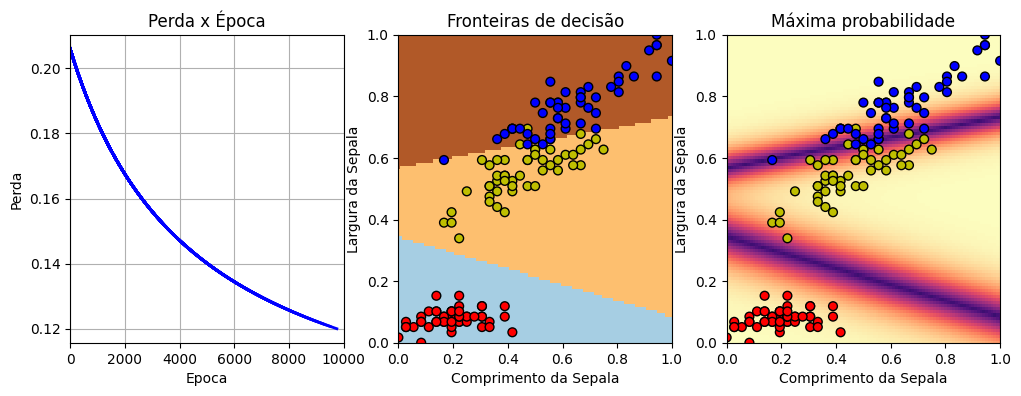

In [ ]:
lr = 0.5

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
nb_epoch = 10000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    # calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())

    my_plot.on_epoch_end(i, {'loss': loss.data.item()});
    final_loss = loss.data.item()

print('Final loss:', final_loss)

Final loss: 0.09761635959148407


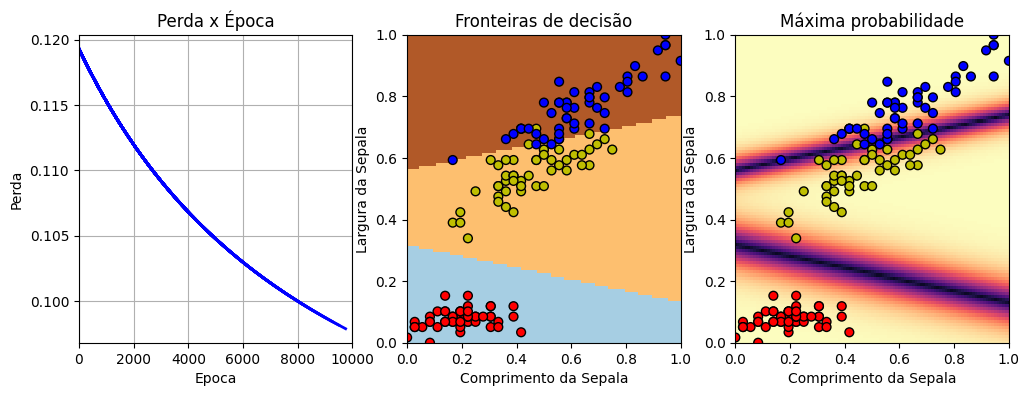

In [ ]:
lr = 0.8

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
nb_epoch = 10000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    # calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())

    my_plot.on_epoch_end(i, {'loss': loss.data.item()});
    final_loss = loss.data.item()

print('Final loss:', final_loss)

### Exercícios:

1. Observando o gráfico de máxima probabilidade, responda:
    1. Qual é a amostra classificada corretamente, com maior probabilidade?
    
    2. Qual é a amostra classificada erradamente, com maior probabilidade?
    
    3. Qual é a amostra classificada corretamente, com menor probabilidade?
    4. Qual é a amostra classificada erradamente, com menor probabilidade?
2. Quantos parâmetros possui esta rede? Quantos são da camada densa e quantos são de bias?
3. Quantas entradas e quantas saídas esta rede possui?
4. Como se pode calcular a acurácia a partir da matriz de confusão?
5. O que faz a função `torch.max`? Quantos parâmetros ela retorna e quais seus significados?
    - http://pytorch.org/docs/master/torch.html?highlight=torch%20max#torch.max

#### 1. Observando o gráfico de máxima probabilidade, responda:

##### A. Qual é a amostra classificada corretamente, com maior probabilidade?

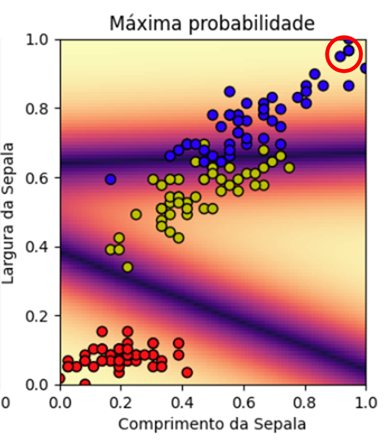

#### B. Qual é a amostra classificada erradamente, com maior probabilidade?

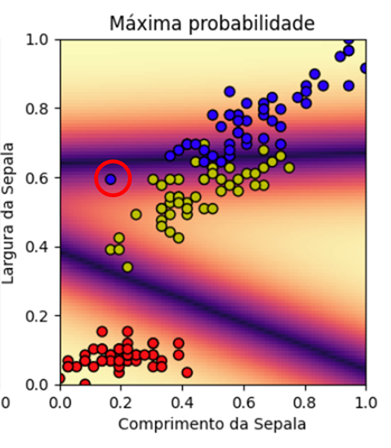

#### C. Qual é a amostra classificada corretamente, com menor probabilidade?

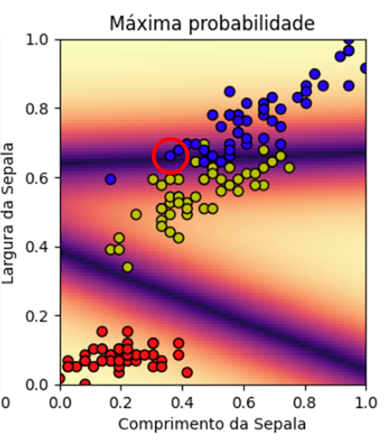

#### D. Qual é a amostra classificada erradamente, com menor probabilidade?

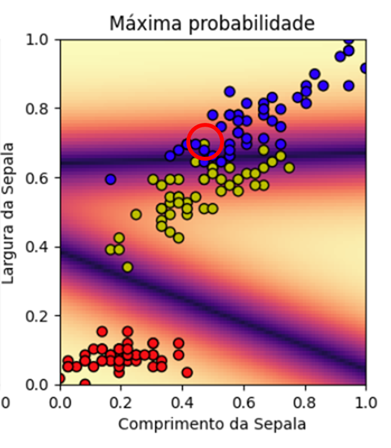

#### 2. Quantos parâmetros possui esta rede? Quantos são da camada densa e quantos são de bias?
<br>6 parâmetros da camada densa (2 entradas e 3 saídas).
<br>3 parâmetros de bias (1 para cada saída).
<br>**Total**: 9 Parâmetros

3. Quantas entradas e quantas saídas esta rede possui?
<br>2 entradas e 3 saídas

4. Como se pode calcular a acurácia a partir da matriz de confusão?
<br>Fazendo a divisão entre a quantidade de acertos (classificações corretas) e o total de classificações
<br>`accuracy_cm = np.trace(confusion_matrix) / confusion_matrix.values.sum()`

5. O que faz a função `torch.max`? Quantos parâmetros ela retorna e quais seus significados?
<br>A função `torch.max` encontra o valor máximo de um tensor e seu índice.
<br>A saída dessa função depende dos parâmetros informados na entrada.
- Se na entrada for informado **apenas o tensor**, apenas um parâmetro é retornado: `value` o valor máximo global do tensor
- Se na entrada for informado o **tensor** e especificada a **dimensão**, o retorno é uma tupla com o valor máximo de cada linha naquela dimensão e seus respectivos índices
<br>Exemplo:

In [40]:
a = torch.randn(4, 4)
print(">>Tensor:")
print(a)
print("\n>>Informando apenas o tensor:")
print(torch.max(a))
print("\n>>Informando o tensor e a dimensão:")
print(torch.max(a, 1))

>>Tensor:
tensor([[ 1.1080, -0.4080, -0.9256, -0.0980],
        [ 0.0035,  0.6609, -0.1460,  0.7254],
        [ 1.4715, -0.1464,  0.3581, -1.1015],
        [-0.8840, -0.1802, -0.8782,  2.0454]])

>>Informando apenas o tensor:
tensor(2.0454)

>>Informando o tensor e a dimensão:
torch.return_types.max(
values=tensor([1.1080, 0.7254, 1.4715, 2.0454]),
indices=tensor([0, 3, 0, 3]))


## Principais aprendizados

Aprendemos sobre o uso da regressão logística para a classificação dos dados de entrada.
<br>Calculo da probabilidade para cada classe encontrada através da função `softmax`.
<br>Cálculo da acurácia diretamente e a partir da matriz de confusão.
<br>Interpretação do gráfico de máxima probabilidade.